###Import и загрузка данных

In [41]:
# базовые
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # разделение на обучающую и тестовую выборки
from sklearn.model_selection import GridSearchCV #подбор гиперпараметров методом сетки

# ML classification
from sklearn.neighbors import KNeighborsClassifier # метод ближайших соседей

# metrics
from sklearn.metrics import make_scorer, f1_score, recall_score
from sklearn.metrics import (confusion_matrix,  # матрица ошибок
                             accuracy_score,    # точность
                             precision_score,   # способность определять конкретный класс
                             recall_score,      # полнота алгоритма
                             f1_score,          # средневзвешенная
                             auc,               # значение auc
                             roc_curve,         # кривая
                             roc_auc_score      # метрика
                             )

# балансировка
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler


from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline

In [42]:
!git clone https://github.com/OlgaManakova2021/Data.git

fatal: destination path 'Data' already exists and is not an empty directory.


In [43]:
path = '/content/Data/bank.csv'

In [44]:
bank_df = pd.read_csv(path, sep = ';')
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


#Анализ данных

In [45]:
bank_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

Целевая переменная y - оформил ли клиент подписку на депозит

In [46]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


В наборе данных нет нулевых значений. 7 объектов являются числовыми, 10 значений являются категориальными

In [47]:
bank_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [48]:
bank_df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521
unique,12,3,4,2,2,2,3,12,4,2
top,management,married,secondary,no,yes,no,cellular,may,unknown,no
freq,969,2797,2306,4445,2559,3830,2896,1398,3705,4000


In [49]:
bank_df.rename(columns ={'y':'deposit'} , inplace = True)

In [50]:
bank_df['deposit'].value_counts()

,count
deposit,
no,4000
yes,521


Датасет разбалансирован - 4000 клиентов не оформили подписку, а 521 - оформили

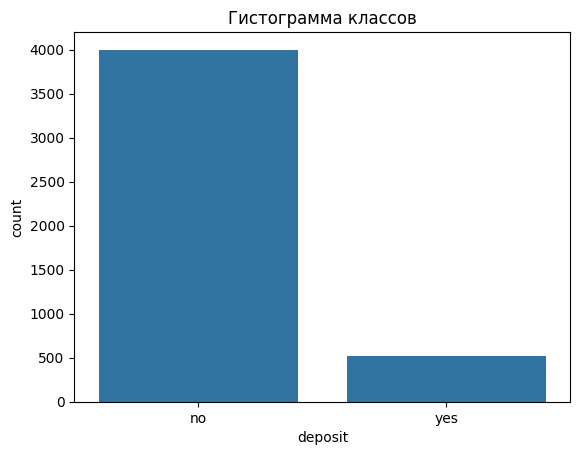

In [51]:
sns.countplot(data=bank_df, x=bank_df['deposit'])
plt.title('Гистограмма классов')
plt.show()

In [52]:
cat_cols = bank_df.describe(include='object').columns.to_list()
cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'deposit']

In [53]:
cat_data = bank_df[cat_cols]
cat_data.head()

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
0,unemployed,married,primary,no,no,no,cellular,oct,unknown,no
1,services,married,secondary,no,yes,yes,cellular,may,failure,no
2,management,single,tertiary,no,yes,no,cellular,apr,failure,no
3,management,married,tertiary,no,yes,yes,unknown,jun,unknown,no
4,blue-collar,married,secondary,no,yes,no,unknown,may,unknown,no


По признакам, имеющим по два значения (yes/no) выполним кодирование вручную

In [54]:
yes_no_cols = []
for col in cat_cols:
    unique_values = set(bank_df[col].unique())
    if unique_values == {'yes', 'no'} or unique_values == {'no', 'yes'}:
        yes_no_cols.append(col)

print(yes_no_cols)

['default', 'housing', 'loan', 'deposit']


In [55]:
for col in yes_no_cols:
  bank_df[col].replace(to_replace='yes', value=1, inplace=True)
  bank_df[col].replace(to_replace='no',  value=0, inplace=True)

bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,0,4789,1,1,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,0,1350,1,0,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,0,1476,1,1,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,may,226,1,-1,0,unknown,0


Преобразуем категории в бинарные столбцы

In [56]:
bank_df = pd.get_dummies(bank_df, columns=['job', 'marital', 'education', 'contact', 'month', 'poutcome'], drop_first=True)

In [57]:
bank_df.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,30,0,1787,0,0,19,79,1,-1,0,...,False,False,False,False,False,True,False,False,False,True
1,33,0,4789,1,1,11,220,1,339,4,...,False,False,False,True,False,False,False,False,False,False
2,35,0,1350,1,0,16,185,1,330,1,...,False,False,False,False,False,False,False,False,False,False
3,30,0,1476,1,1,3,199,4,-1,0,...,False,True,False,False,False,False,False,False,False,True
4,59,0,0,1,0,5,226,1,-1,0,...,False,False,False,True,False,False,False,False,False,True


In [58]:
bank_df.shape

(4521, 43)

In [59]:
bank_df.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'deposit', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'contact_telephone', 'contact_unknown', 'month_aug', 'month_dec',
       'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'],
      dtype='object')

In [60]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  4521 non-null   int64
 1   default              4521 non-null   int64
 2   balance              4521 non-null   int64
 3   housing              4521 non-null   int64
 4   loan                 4521 non-null   int64
 5   day                  4521 non-null   int64
 6   duration             4521 non-null   int64
 7   campaign             4521 non-null   int64
 8   pdays                4521 non-null   int64
 9   previous             4521 non-null   int64
 10  deposit              4521 non-null   int64
 11  job_blue-collar      4521 non-null   bool 
 12  job_entrepreneur     4521 non-null   bool 
 13  job_housemaid        4521 non-null   bool 
 14  job_management       4521 non-null   bool 
 15  job_retired          4521 non-null   bool 
 16  job_self-employed    452

Все признаки преобразованы к числовым значениям

In [61]:
bank = bank_df.copy()
corr_bank = bank.drop("deposit", axis=1).apply(lambda x: x.corr(bank.deposit))

## Смотрим корреляцию

In [62]:
corr_sort = corr_bank.sort_values(ascending=False)

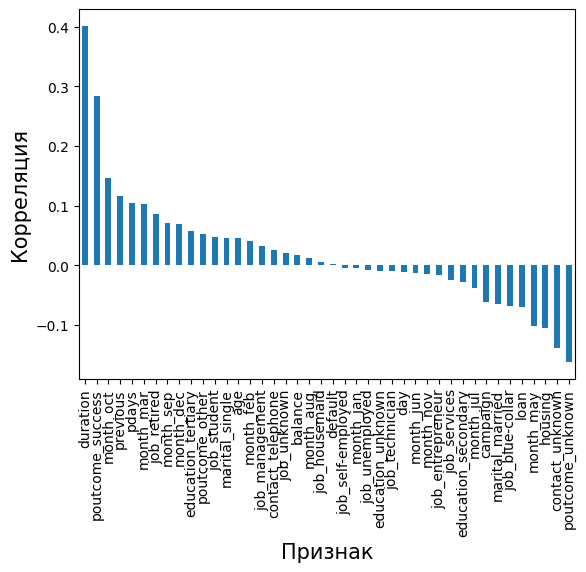

In [63]:
corr_sort.plot.bar()
plt.xlabel("Признак", fontsize=15)
plt.ylabel("Корреляция", fontsize=15)
plt.show()

In [64]:
y = np.array(bank_df['deposit'])
X = np.array(bank_df.drop(['deposit', 'duration'], axis=1))

#Разделим датасет на тренировочную и обучающую выборки

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3616, 41)
(905, 41)
(3616,)
(905,)


In [66]:
scaler = StandardScaler()
x_train_scl = scaler.fit_transform(X_train)
x_test_scl = scaler.transform(X_test)

In [67]:
kNN = KNeighborsClassifier(n_neighbors=1, metric='manhattan')

In [68]:
kNN.fit(x_train_scl, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

In [69]:
y_pred = kNN.predict(x_test_scl)

In [70]:
print(f'F1-score = {f1_score(y_test, y_pred):.4f}')
print(f'Accuracy = {accuracy_score(y_test, y_pred):.4f}')
print(f'Recall = {recall_score(y_test, y_pred):.4f}')
print(f'Precision = {precision_score(y_test, y_pred):.4f}')

F1-score = 0.2059
Accuracy = 0.8210
Recall = 0.2143
Precision = 0.1981


При несбалансированных данных Accuracy бесполезна — модель может предсказывать только majority класс и получить высокий %, игнорируя minority

#Выбор метода балансировки

In [80]:
# 1. Определение методов балансировки
methods = {
    'NearMiss1': NearMiss(version=1),  # Используем NearMiss-1
    'NearMiss2': NearMiss(version=2),  # Используем NearMiss-2
    'NearMiss3': NearMiss(version=3),  # Используем NearMiss-3
    'RUS': RandomUnderSampler(sampling_strategy = 'majority'),
    'SMOTE': SMOTE(sampling_strategy='minority'),
}

# 2. Кросс-валидация для оценки производительности
results = {}

for method_name, method in methods.items():
  X_balance, y_balance = method.fit_resample(X, y)
  # Оценка модели с использованием кросс-валидации
  f1_scores = cross_val_score(kNN, X_balance, y_balance, cv=5, scoring=make_scorer(f1_score))
  recall_scores = cross_val_score(kNN, X_balance, y_balance, cv=5, scoring=make_scorer(recall_score))
  ROC_AUC = cross_val_score(kNN, X_balance, y_balance, cv=5, scoring=make_scorer(roc_auc_score))
  results[method_name] = [f1_scores.mean(), recall_scores.mean(), ROC_AUC.mean()]

# 3. Вывод результатов
for method_name, score in results.items():
    print(f"{method_name}: F1 Score = {score[0]:.4f},  Recall = {score[1]:.4f}, ROC-AUC = {score[2]:.4f}")


NearMiss1: F1 Score = 0.8024,  Recall = 0.7658, ROC-AUC = 0.8090
NearMiss2: F1 Score = 0.6526,  Recall = 0.8753, ROC-AUC = 0.5345
NearMiss3: F1 Score = 0.5508,  Recall = 0.5932, ROC-AUC = 0.5155
RUS: F1 Score = 0.5317,  Recall = 0.5124, ROC-AUC = 0.5499
SMOTE: F1 Score = 0.8392,  Recall = 0.9328, ROC-AUC = 0.8213


# Подбор гиперпараметров методом сетки

In [86]:
# Создание пайплайна
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__metric': ['euclidean', 'manhattan']
    }

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1') # accuracy, recall, f1, precision
grid_search.fit(X_balance, y_balance)
print(f'Лучшие параметры: {grid_search.best_params_}')
#print(f'Готовая модель с лучшими параметрами: {grid_search.best_estimator_}')
print(f'Лучшая точность: {grid_search.best_score_:.4f}')

Лучшие параметры: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3}
Лучшая точность: 0.9239


#ML - classification

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X_balance, y_balance,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6400, 41)
(1600, 41)
(6400,)
(1600,)


In [88]:
scaler = StandardScaler()
x_train_balance_scl = scaler.fit_transform(X_train)
x_test_balance_scl = scaler.transform(X_test)

In [89]:
kNN = KNeighborsClassifier(n_neighbors=3, metric='manhattan')

In [90]:
kNN.fit(x_train_balance_scl, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=3)

In [91]:
y_pred = kNN.predict(x_test_balance_scl)

In [92]:
model_list =[kNN]
model_name_list = ['kNN']

def get_metrics(model_list,
                model_name_list,
                x_test_balance_scl, y_test
                ):
  for i in range(len(model_list)):
    y_pred = model_list[i].predict(x_test_balance_scl)
    print(f'для модели {model_name_list[i]}')
    print('Confisuion matrix = ')
    print(confusion_matrix(y_test, y_pred))
    print(f'Accuracy = {accuracy_score(y_test, y_pred):.4f}')
    print(f'Precision_score = {precision_score(y_test, y_pred):.4f}')
    print(f'Recall = {recall_score(y_test, y_pred):.4f}')
    print(f'f1 = {f1_score(y_test, y_pred):.4f}')
    print(f'AUC_ROC = {roc_auc_score(y_test, y_pred):.4f}')

In [93]:
get_metrics(model_list, model_name_list, x_test_balance_scl, y_test)

для модели kNN
Confisuion matrix = 
[[722  79]
 [ 51 748]]
Accuracy = 0.9187
Precision_score = 0.9045
Recall = 0.9362
f1 = 0.9200
AUC_ROC = 0.9188
